In [88]:
import matplotlib.pyplot as plt
import mudata; mudata.set_options(pull_on_update=False)
import muon as mu
import numpy as np
import sys; sys.path.append('../')
import torch
from functools import singledispatch, singledispatchmethod, wraps
from inspect import getcallargs
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch_cluster import knn
from torch_geometric import nn as gnn
from torch_geometric.nn.conv import GCNConv, SimpleConv, SGConv
from tqdm import tqdm
from asterism.base import buildmethod, checkmethod, Asterism
from asterism.models.ntm import ATLAS, NTM, RSB
from asterism.models.vae import VQAE
from asterism.utils import get_kwargs, kmeans, relabel, to_list
from asterism.utils.acts import Dirichlet
from asterism.utils.data import make_dataset
from asterism.utils.nets import ACT, NORM, OPTIM, Encoder, MLP, RNN
from asterism.utils.figs import show_comparison, show_dataset

In [160]:
class ATLAS(Asterism, nn.Module):
    def __init__(self, min_topics=1, *, channels=(128, 32), doc_size=8, topic_rate=.2, kld_scale=.1, optim='adam', desc='ATLAS', seed=None):
        super().__init__(desc, seed)

        self.min_topics = min_topics
        self.channels = channels
        self.doc_size = doc_size
        self.topic_rate = topic_rate
        self.kld_scale = kld_scale
        self.optim = optim

        self.n_topics_ = min_topics
        self._channels = (channels,) if isinstance(channels, int) else channels
        self._n_steps = 1000
        self.topic_log_ = []

    def _build(self, X, locs, learning_rate=1e-2, batch_size=128, shuffle=True):
        if batch_size == -1:
            batch_size = X.shape[0]

        self._conv, edges = SimpleConv(), knn(locs, locs, self.doc_size)
        self._loader = DataLoader(self._conv(X, edges), batch_size, shuffle) 
        self._encoder = Encoder(X.shape[1], *self._channels, act_layer='prelu')
        self._dt_rnn = RNN(self._channels[-1], bias=False, act_layer='prelu')
        self._tw_rnn = RNN(self._channels[-1], bias=False, act_layer='prelu')
        self._decoder = MLP(self._channels[-1], X.shape[1], final_bias=False)
        self._optim = OPTIM[self.optim](self.parameters(), lr=learning_rate)
        self.train()

        return self
    
    def _generate(self, Z=None, n_topics=None):
        if n_topics is None:
            n_topics = self.n_topics_

        weights = self._decoder(self._tw_rnn(n_layers=n_topics + 1))

        if Z is not None:
            X = F.softmax(Z@self._dt_rnn(n_layers=n_topics + 1).T, -1)@weights

            return X, weights
        return weights
    
    def _evaluate(self, X):
        Z, kld = self._encoder(X, return_kld=True)
        X_k, _ = self._generate(Z, self.n_topics_ - 1)
        X_K, weights = self._generate(Z)
        loss_k = (X_k - X).square().sum(-1)/X.shape[0]
        loss_K = (X_K - X).square().sum(-1)/X.shape[0]

        if self.n_topics_ > (X@weights.T).argmax(-1).unique().shape[0]:
            self.n_topics_ -= 1
        elif (loss_k - loss_K).sum()/loss_K.sum() > self.topic_rate:
            self.n_topics_ += 1

        loss = loss_K.sum().sqrt() + self.kld_scale*kld

        return loss
    
    def _step(self):
        loss = 0.

        for X in self._loader:
            X_loss = self._evaluate(X)
            X_loss.backward()
            loss += X_loss.item()

        self._optim.step()
        self._optim.zero_grad()
        self.topic_log_.append(self.n_topics_)

        return loss
    
    def _predict(self, X, locs, eval=True):
        if eval:
            self.eval()

        edges = knn(locs, locs, self.doc_size)
        X_, weights = self._conv(X, edges), self._generate()
        topics = (X_@weights.T).argmax(-1).detach()

        return topics


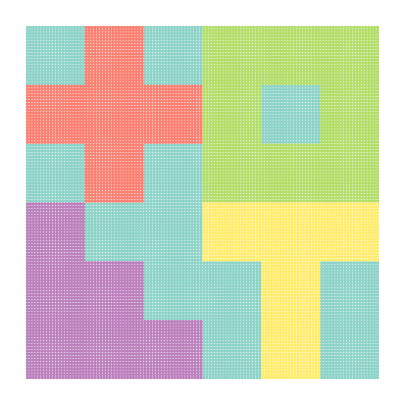

In [171]:
data, locs, labels = make_dataset(block_size=20, return_tensor=True)
show_dataset(locs, labels, size=2)

ATLAS: 100%|██████████| 1000/1000 [08:03<00:00,  2.07it/s]


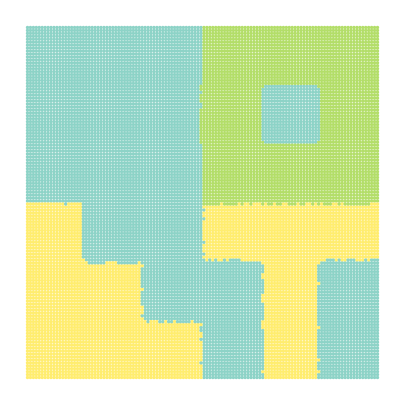

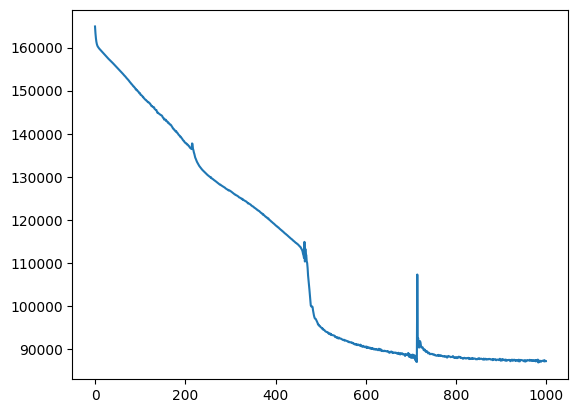

In [172]:
model = ATLAS()
topics = model.fit_predict(data, locs=locs, learning_rate=1e-3)
show_dataset(locs, topics, size=2)
plt.plot(range(len(model.log_)), model.log_)
plt.show()

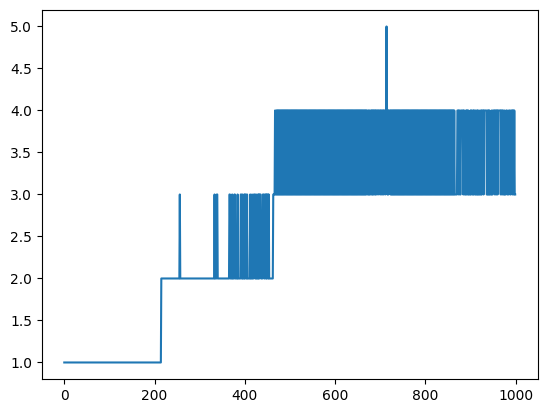

In [173]:
plt.plot(range(len(model.topic_log_)), model.topic_log_)
plt.show()

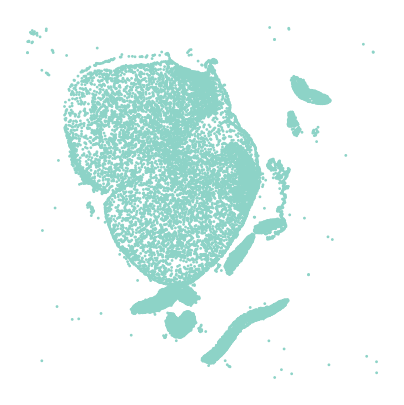

In [174]:
mdata = mu.read('spine.h5mu')
data = torch.tensor(mdata['protein'].X)
locs = torch.tensor(mdata['physical'].obsm['spatial'])
show_dataset(locs, size=1)

KMeans: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


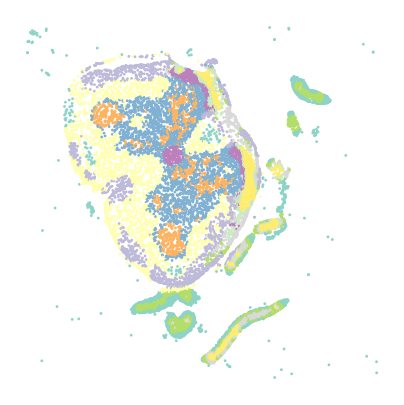

In [94]:
conv, edges = SimpleConv(), knn(locs, locs, 128)
topics = kmeans(conv(data, edges), 10)
show_dataset(locs, topics, size=1)

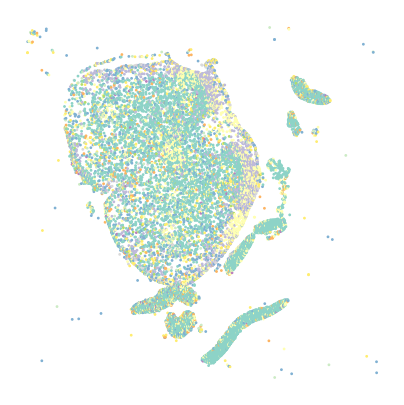

In [95]:
conv, edges = SimpleConv(), knn(locs, locs, 128)
encoder = Encoder(data.shape[1], 128, 32, act_layer='prelu')
dt_rnn = RNN(32, bias=False, act_layer='prelu')
tw_rnn = RNN(32, bias=False, act_layer='prelu')
show_dataset(locs, F.softmax(encoder(conv(data, edges))@dt_rnn(n_layers=10).T, -1).argmax(-1).detach(), size=1)

ATLAS: 100%|██████████| 1000/1000 [04:34<00:00,  3.64it/s]


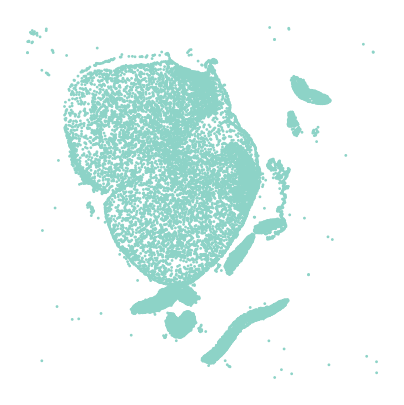

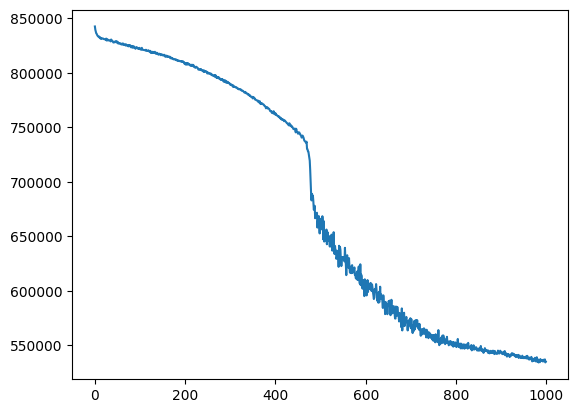

In [175]:
model = ATLAS()
topics = model.fit_predict(data, locs=locs, learning_rate=1e-3)
show_dataset(locs, topics, size=1)
plt.plot(range(len(model.log_)), model.log_)
plt.show()

In [176]:
model.n_topics_

1

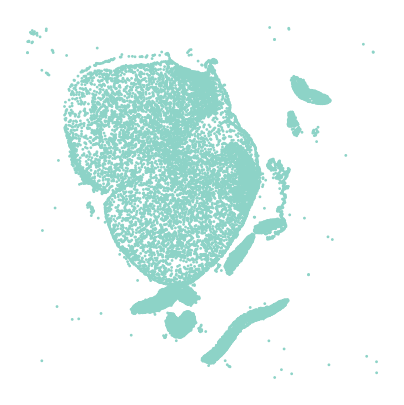

In [170]:
weights = model._decoder(model._tw_rnn(n_layers=model.n_topics_ + 1))
show_dataset(locs, (data.repeat(1, 1)@weights.T).argmax(-1), size=1)

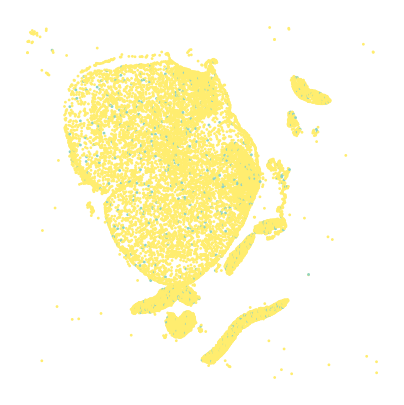

In [169]:
Z = model._encoder(data.repeat(1, 1))
show_dataset(locs, F.softmax(Z@model._dt_rnn(n_layers=model.n_topics_ + 1).T, -1).argmax(-1), size=1)